<h1>Medicare Charges Prediction</h1>
<h3>We will be using the Hospital Charges for Inpatients dataset to determine if Deep Learning has an advantage at regression modeling. This is a dataset of 163K rows of hospital charge records from 3337 physicians.
Our goal is to use the data to predict the average Medicare charges for physicians. Note that the original dataset has been modified to use for regression. The "Average Total Payments" field had a 98% correlation with Medicare charges, as a result it was omitted.</h3>


<h2>Method 1: Row Level Regression</h2>
<h3>In this simplest example we will attempt to predict the Medicare charge for each row of data.</h3>

<h2>Step 1: Import and Process Data</h2>

<h3>We will use Pandas to import the Excel file and do some exploratory data analysis</h3>

In [25]:
import pandas as pd 
import numpy as np
import warnings
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
warnings.simplefilter('ignore')

%matplotlib inline
import seaborn as sns

sns.set_theme(style='white')
sns.set(rc={'figure.figsize':(20, 5)})
sns.set(font_scale=1.1) 


In [3]:
excel_file = pd.ExcelFile('providers.xlsx')

In [4]:
df = excel_file.parse('original')

In [5]:
df.head()

,DRG Definition,Provider Id,Provider Name,Provider Street Address,Provider City,Provider State,Provider Zip Code,Hospital Referral Region Description,Total Discharges,Average Covered Charges,y
0,039 - EXTRACRANIAL PROCEDURES W/O CC/MCC,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,91,32963.07,4763.73
1,057 - DEGENERATIVE NERVOUS SYSTEM DISORDERS W/...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,38,20312.78,3865.50
2,064 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,84,38820.39,9167.08
3,065 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,169,27345.10,5438.50
4,066 - INTRACRANIAL HEMORRHAGE OR CEREBRAL INFA...,10001,SOUTHEAST ALABAMA MEDICAL CENTER,1108 ROSS CLARK CIRCLE,DOTHAN,AL,36301,AL - Dothan,33,17605.51,3618.93


<h3>We will delete Provider Name, Street Address, City, Zip Code and Region as these variables have too much cardinality and Provider Name is largely redundant to Id.</h3>

In [6]:
df = df[['DRG Definition', 'Provider Id', 'Provider State', ' Total Discharges ', ' Average Covered Charges ', 'y']]
df.columns = ['DRG_Definition', 'Provider_Id', 'Provider_State', 'Total_Discharges', 'Average_Covered_Charges', 'y']

<h3>Split the dataset into a training and test set, 80/20 split. We will use a random seed to ensure reproducability. In the next analysis we will explore the value of adding sequences, as a result we will split the data by doctors instead of simply by rows.</h3>

In [7]:
#use a random seed for reproducability
import random
random.seed(123)

In [8]:
#randomly select 80% of doctors and use them as the training set, the remaining 20% will be used for testing 
Xtrain_docs = random.sample(list(df['Provider_Id'].unique()), int(len(df['Provider_Id'].unique()) * 0.8))
Xtest_docs = [x for x in list(df['Provider_Id'].unique()) if x not in Xtrain_docs]

In [9]:
train_keys = [int(1)]* len(Xtrain_docs)

In [10]:
test_keys = [int(0)] * len(Xtest_docs)

In [11]:
map_dict = Xtrain_docs +Xtest_docs 
map_keys = train_keys + test_keys 
map_dict2 = dict(zip(map_dict, map_keys))

In [12]:
df['Test or Train'] = df['Provider_Id'].map(map_dict2)

In [13]:
df['Test or Train'].value_counts()/len(df['Test or Train'])

1    0.800221
0    0.199779
Name: Test or Train, dtype: float64

<h3>We will simply label the training dataset doctors with a 1 and the test set with a 0 so that we can easily split the dataset</h3>

In [14]:
Xtrain = df[df['Test or Train'] == 1]
Xtest = df[df['Test or Train'] == 0]

In [15]:
ytrain = Xtrain[['y']]
ytest = Xtest[['y']]
Xtrain.drop(columns=['y'], inplace=True)
Xtest.drop(columns=['y'], inplace=True)
Xtrain_unscaled = Xtrain.copy()
Xtest_unscaled = Xtest.copy()

In [16]:
ytrain_index = ytrain.index 
ytest_index = ytest.index

<h2>Feature Engineering</h2>
<h3>There are 100 DRG Definitions and over 50 Provider States, creating dummy variables for each would cause the size of the dataset to explode. To keep these features in the dataset without increasing the number of columns we will use mean ordering where we replace the categorical value with the ranking based on the mean of the target variable. In theory this should lead to better results, but since we are using the training set only to perform the ordering it could possibly lead to overfitting.
We will observe the distribution of the target variable to see if we can perform a transformation that will make it closer to normally distributed if the target variable isn't</h3>
<h2>Normal Distributions</h2>
<h3>Some models, particularly linear models which have a normality assumption, benefit from having features with a "normal distribution". As a result, we will transform the target value and features to get a more normal distribution. Even for non-linear models, better separation of data may lead to better model results.</h3>

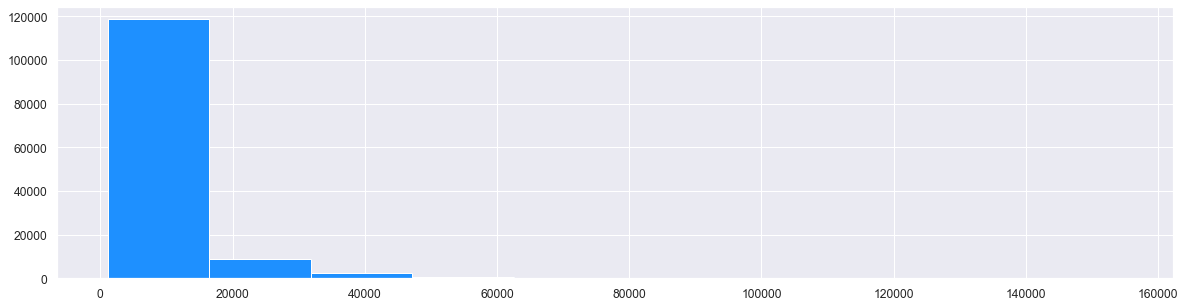

In [36]:
plt.hist(ytrain.values, color='DodgerBlue')
plt.show()

In [37]:
ytrainlog = np.log(ytrain)
ytrainlog.head()

,y
0,8.468786
1,8.259846
2,9.123374
3,8.601259
4,8.193934


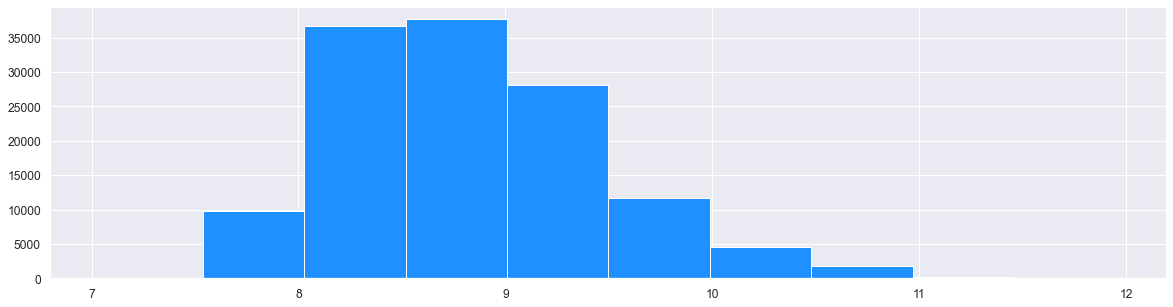

In [39]:
plt.hist(ytrainlog.values, color='DodgerBlue')
plt.show()

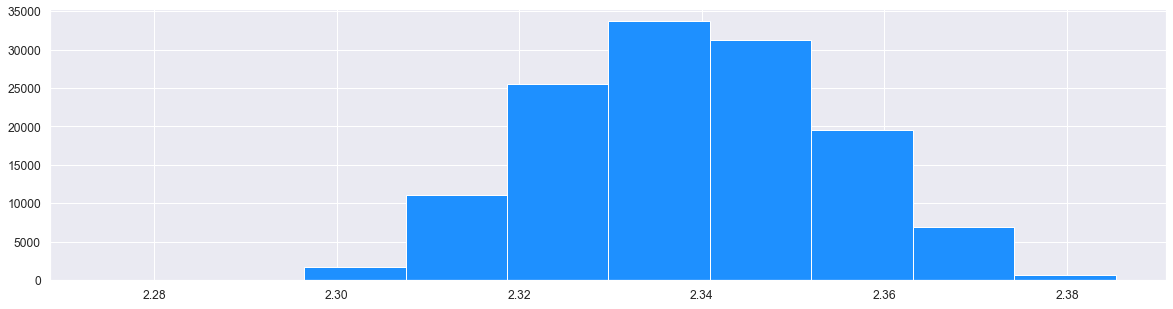

In [40]:
import scipy.stats as stats 
y_1, param = stats.yeojohnson(ytrain)
plt.hist(y_1, color='DodgerBlue')
plt.show()

In [41]:
ytrain_unscaled = ytrain.copy()
ytest_unscaled = ytest.copy()
ytrain, param = stats.yeojohnson(ytrain)
ytest = stats.yeojohnson(ytest, lmbda=param)

In [42]:
ytrain = pd.DataFrame(ytrain, columns=['y'], index=ytrain_index)
ytest = pd.DataFrame(ytest, columns=['y'], index = ytest_index)

In [43]:
#this formula will convert categorical variables into a category ranking based on the average value of the target
def order_categories(Xtrain, Xtest, ytrain, ytest, categories, target):
    dftrain = pd.concat([Xtrain, ytrain], axis=1).copy()
    dftest = pd.concat([Xtest, ytest], axis=1).copy()
    for col in categories:
        ordered_labels = dftrain.groupby(col).mean().sort_values(by=target).index
        ordinal_label = {k: i for i,k in enumerate(ordered_labels, 0)}
        dftrain[col] = dftrain[col].map(ordinal_label)
        dftest[col] = dftest[col].map(ordinal_label)
    dftrain.drop([target], axis=1, inplace= True)
    dftest.drop([target], axis=1, inplace=True)
    
    return dftrain, dftest

In [44]:
Xtrain, Xtest = order_categories(Xtrain, Xtest, ytrain, ytest, ['Provider_State', 'DRG_Definition'], 'y')
Xtrain_unscaled, Xtest_unscaled = order_categories(Xtrain_unscaled, Xtest_unscaled, ytrain_unscaled, ytest_unscaled, ['Provider_State', 'DRG_Definition'], 'y')

In [45]:
Xtrain = Xtrain.drop(columns=[ 'Provider_Id'])
Xtest = Xtest.drop(columns=['Provider_Id'])

In [46]:
Xtrain.drop(columns=['Test or Train'], axis=1, inplace=True)
Xtest.drop(columns=['Test or Train'],axis=1, inplace=True)

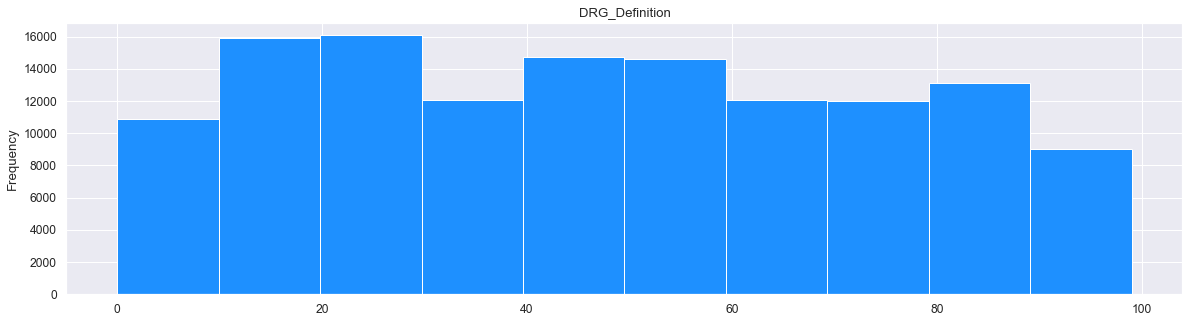

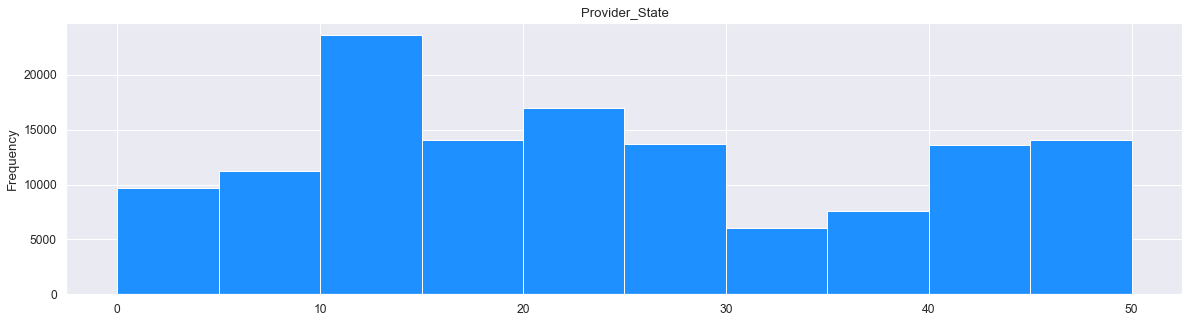

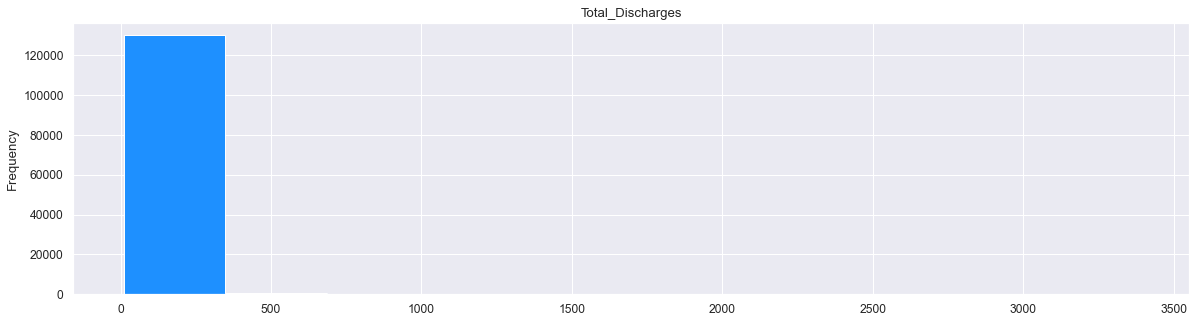

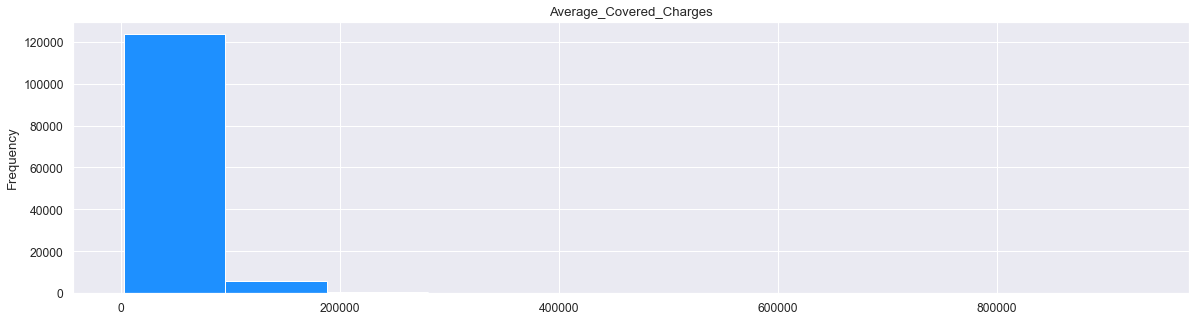

In [47]:
for col in Xtrain.columns:
    tmp = Xtrain[col]
    tmp.plot.hist(color='DodgerBlue')
    plt.title(col)
    plt.show()

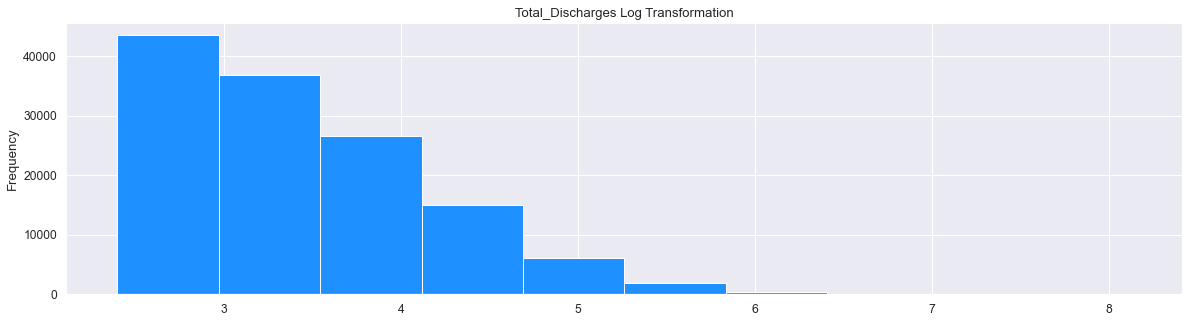

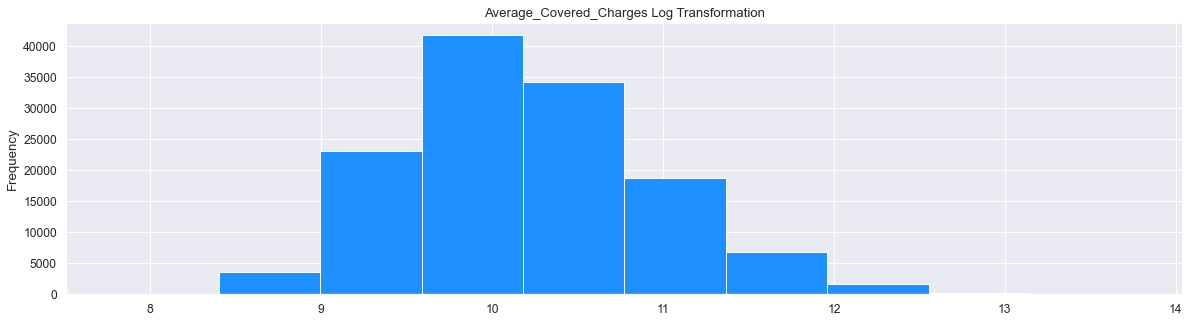

In [48]:
for col in ['Total_Discharges', 'Average_Covered_Charges']:
    tmp = np.log(Xtrain[col])
    tmp.plot.hist(color='DodgerBlue')
    plt.title(str(col) +  ' Log Transformation')
    plt.show()

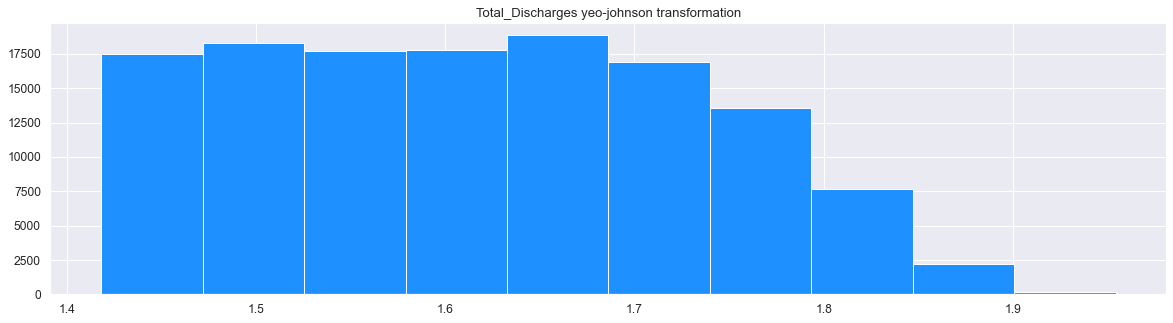

In [49]:
for col in ['Total_Discharges']:
    tmp, param = stats.yeojohnson(Xtrain[col])
    plt.hist(tmp, color='DodgerBlue')
    plt.title(str(col) + ' yeo-johnson transformation')
    plt.show()

<h3>Based on the transformation outputs, we will utilize a log transformation for "Average Covered Charges" and a yeo-johnson transformation for "Total Discharges"</h3>

In [50]:
Xtrain['Average_Covered_Charges'] =  np.log(Xtrain['Average_Covered_Charges'])
Xtest['Average_Covered_Charges'] =  np.log(Xtest['Average_Covered_Charges'])
Xtrain['Total_Discharges'], param =  stats.yeojohnson(Xtrain['Total_Discharges'])
Xtest['Total_Discharges'] =  stats.yeojohnson(Xtest['Total_Discharges'], lmbda = param)

In [51]:
Xtrain.describe()

,DRG_Definition,Provider_State,Total_Discharges,Average_Covered_Charges
count,130488.000000,130488.000000,130488.000000,130488.000000
mean,47.196317,23.480925,1.617079,10.200579
std,27.720530,13.824511,0.118632,0.724180
min,0.000000,0.000000,1.418286,7.807673
25%,24.000000,13.000000,1.523354,9.674882
50%,47.000000,22.000000,1.615900,10.131954
75%,71.000000,37.000000,1.709963,10.668627
max,99.000000,50.000000,1.954355,13.741992


In [52]:
Xtrain_unscaled.describe()

,DRG_Definition,Provider_Id,Provider_State,Total_Discharges,Average_Covered_Charges,Test or Train
count,130488.000000,130488.000000,130488.000000,130488.000000,130488.000000,130488.0
mean,47.138197,256229.433174,24.325118,42.740122,35939.987097,1.0
std,27.823961,151202.489894,13.970093,51.332748,34789.739010,0.0
min,0.000000,10001.000000,0.000000,11.000000,2459.400000,1.0
25%,23.000000,110089.000000,14.000000,17.000000,15912.847500,1.0
50%,47.000000,250048.000000,23.000000,27.000000,25133.430000,1.0
75%,70.000000,380061.000000,36.000000,49.000000,42985.870000,1.0
max,99.000000,670077.000000,50.000000,3383.000000,929118.900000,1.0


In [53]:
from sklearn.preprocessing import MinMaxScaler

In [54]:
scaled_features = Xtrain.copy()
scaled_features2 = Xtest.copy()

col_names = ['DRG_Definition', 'Provider_State', 'Total_Discharges', 'Average_Covered_Charges']
features = scaled_features[col_names]
features2 = scaled_features2[col_names]


scaler = MinMaxScaler().fit(features.values)
features = scaler.transform(features.values)
features2 = scaler.transform(features2.values)

Xtrain[col_names] = features
Xtest[col_names] = features2

yscaler = MinMaxScaler().fit(np.array(ytrain).reshape(-1, 1))
ytrain = yscaler.transform(np.array(ytrain).reshape(-1, 1))
ytest = yscaler.transform(np.array(ytest).reshape(-1, 1))

<h2>Step 2: Machine Learning Algorithm Comparison</h2>
<h3>We will compare Deep Learning to Linear Regression, Ridge Regression, Support Vector Machine Regression, Gradient Boosting, AdaBoost and XGBoost</h3>

In [56]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import tensorflow as tf
from sklearn.linear_model import LinearRegression, Ridge
from sklearn import svm
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor

<h2>Linear Regression</h2>
<h3>Unscaled</h3>

In [57]:
lr = LinearRegression()
lr.fit(Xtrain_unscaled, ytrain_unscaled)
ytrain_pred_unscaled = lr.predict(Xtrain_unscaled)

In [59]:
print('The mean squared error of the model on the training set is: ', mean_squared_error(ytrain_unscaled, ytrain_pred_unscaled ))
ytest_pred_unscaled = lr.predict(Xtest_unscaled)
print('The mean squared error of the model on the test set is: ', mean_squared_error(ytest_unscaled, ytest_pred_unscaled))

The mean squared error of the model on the training set is:  14966417.46693095
The mean squared error of the model on the test set is:  15247241.910642186


In [60]:
print('The RSquared score on the training set is: ' , r2_score(ytrain_unscaled, ytrain_pred_unscaled))
print('The RSquared score on the test set is: ' , r2_score(ytest_unscaled, ytest_pred_unscaled))

The RSquared score on the training set is:  0.7195901047388807
The RSquared score on the test set is:  0.7157579915330547


In [62]:
testing_tracker = []
testing_tracker.append(['Lin Reg Unscaled',  mean_squared_error(ytest_unscaled, ytest_pred_unscaled), r2_score(ytest_unscaled, ytest_pred_unscaled)])

<h3>Scaled</h3>

In [63]:
lr = LinearRegression()
lr.fit(Xtrain, ytrain)
ytrain_pred = lr.predict(Xtrain)

In [65]:
print('The mean squared error of the model on the training set is: ', mean_squared_error(ytrain, ytrain_pred ))
ytest_pred = lr.predict(Xtest)
print('The mean squared error of the model on the test set is: ', mean_squared_error(ytest, ytest_pred))

The mean squared error of the model on the training set is:  0.0023802453442954914
The mean squared error of the model on the test set is:  0.0022344811562814374


In [66]:
print('The RSquared score on the training set is: ' , r2_score(ytrain, ytrain_pred))
print('The RSquared score on the test set is: ' , r2_score(ytest, ytest_pred))

The RSquared score on the training set is:  0.8749944988984167
The RSquared score on the test set is:  0.8832603511458895


In [67]:
testing_tracker.append(['Lin Reg',  mean_squared_error(ytest, ytest_pred), r2_score(ytest, ytest_pred) ])


<h2>Ridge Regression</h2>

In [69]:
rr = Ridge()
rr.fit(Xtrain, ytrain)
ytrain_pred2 = rr.predict(Xtrain)
ytest_pred2 = rr.predict(Xtest)

In [70]:
print('The mean squared error of the model on the training set is: ', mean_squared_error(ytrain, ytrain_pred2 ))
print('The mean squared error of the model on the test set is: ', mean_squared_error(ytest, ytest_pred2))

The mean squared error of the model on the training set is:  0.0023802454748357723
The mean squared error of the model on the test set is:  0.002234493490468066


In [71]:
print('The RSquared score on the training set is: ' , r2_score(ytrain, ytrain_pred2))
print('The RSquared score on the test set is: ' , r2_score(ytest, ytest_pred2))

The RSquared score on the training set is:  0.8749944920427145
The RSquared score on the test set is:  0.8832597067508308


In [72]:
testing_tracker.append(['Ridge Reg',  mean_squared_error(ytest, ytest_pred2), r2_score(ytest, ytest_pred2) ])

<h2>AdaBoost</h2>

In [74]:
adar = AdaBoostRegressor()
adar.fit(Xtrain, ytrain)
ytrain_pred_adar = adar.predict(Xtrain)
print(mean_squared_error(ytrain, ytrain_pred_adar))
ytest_pred_adar = adar.predict(Xtest)

0.0028419165662429465


In [76]:
print('The mean squared error of the model on the training set is: ', mean_squared_error(ytrain, ytrain_pred_adar ))
print('The mean squared error of the model on the test set is: ', mean_squared_error(ytest, ytest_pred_adar))

The mean squared error of the model on the training set is:  0.0028419165662429465
The mean squared error of the model on the test set is:  0.0027235162150641787


In [77]:
print('The RSquared score on the training set is: ' , r2_score(ytrain, ytrain_pred_adar))
print('The RSquared score on the test set is: ' , r2_score(ytest, ytest_pred_adar))

The RSquared score on the training set is:  0.8507484930897998
The RSquared score on the test set is:  0.8577108937789482


In [78]:
testing_tracker.append(['AdaBoost',  mean_squared_error(ytest, ytest_pred_adar), r2_score(ytest, ytest_pred_adar) ])

<h2>Gradient Boosting</h2>

In [80]:
gbr = GradientBoostingRegressor()
gbr.fit(Xtrain, ytrain) 
ytrain_pred_gbr = gbr.predict(Xtrain)
print(mean_squared_error(ytrain, ytrain_pred_gbr))
ytest_pred_gbr = gbr.predict(Xtest)

0.0019637654063100357


In [81]:
print('The mean squared error of the model on the training set is: ', mean_squared_error(ytrain, ytrain_pred_gbr ))
print('The mean squared error of the model on the test set is: ', mean_squared_error(ytest, ytest_pred_gbr))

The mean squared error of the model on the training set is:  0.0019637654063100357
The mean squared error of the model on the test set is:  0.0017174804026535465


In [82]:
print('The RSquared score on the training set is: ' , r2_score(ytrain, ytrain_pred_gbr))
print('The RSquared score on the test set is: ' , r2_score(ytest, ytest_pred_gbr))

The RSquared score on the training set is:  0.8968671531066903
The RSquared score on the test set is:  0.9102708659878543


In [84]:
testing_tracker.append(['Grad. Boosting',  mean_squared_error(ytest, ytest_pred_gbr), r2_score(ytest, ytest_pred_gbr)])

<h2>XGBoost</h2>

In [87]:
from xgboost import XGBRegressor

In [88]:
xgbru = XGBRegressor()
xgbru.fit(Xtrain_unscaled, ytrain_unscaled) 
ytrain_pred_xgbr_unscaled = xgbru.predict(Xtrain_unscaled)
print(mean_squared_error(ytrain, ytrain_pred_xgbr_unscaled))
ytest_pred_xgbr_unscaled = xgbru.predict(Xtest_unscaled)

122268683.32604058


In [89]:
print('The mean squared error of the model on the training set is: ', mean_squared_error(ytrain_unscaled, ytrain_pred_xgbr_unscaled ))
print('The mean squared error of the model on the test set is: ', mean_squared_error(ytest_unscaled, ytest_pred_xgbr_unscaled))

The mean squared error of the model on the training set is:  2031786.9362609182
The mean squared error of the model on the test set is:  4666202.183635841


In [90]:
print('The RSquared score on the training set is: ' , r2_score(ytrain_unscaled, ytrain_pred_xgbr_unscaled))
print('The RSquared score on the test set is: ' , r2_score(ytest_unscaled, ytest_pred_xgbr_unscaled))

The RSquared score on the training set is:  0.9619325624686944
The RSquared score on the test set is:  0.9130117638086562


In [91]:
testing_tracker.append(['Unscaled XGBoost',  mean_squared_error(ytest_unscaled, ytest_pred_xgbr_unscaled), r2_score(ytest_unscaled, ytest_pred_xgbr_unscaled)])

In [93]:
xgbr = XGBRegressor(learning_rate=0.1)
xgbr.fit(Xtrain, ytrain) 
ytrain_pred_xgbr = xgbr.predict(Xtrain)
print(mean_squared_error(ytrain, ytrain_pred_xgbr))
ytest_pred_xgbr = xgbr.predict(Xtest)

0.0018350188607346328


In [94]:
print('The mean squared error of the model on the training set is: ', mean_squared_error(ytrain, ytrain_pred_xgbr ))
print('The mean squared error of the model on the test set is: ', mean_squared_error(ytest, ytest_pred_xgbr))

The mean squared error of the model on the training set is:  0.0018350188607346328
The mean squared error of the model on the test set is:  0.0016267347918709236


In [95]:
print('The RSquared score on the training set is: ' , r2_score(ytrain, ytrain_pred_xgbr))
print('The RSquared score on the test set is: ' , r2_score(ytest, ytest_pred_xgbr))

The RSquared score on the training set is:  0.9036286520770893
The RSquared score on the test set is:  0.9150118371560537


In [96]:
testing_tracker.append(['XGBoost',  mean_squared_error(ytest, ytest_pred_xgbr), r2_score(ytest, ytest_pred_xgbr) ])

<h2>Explainable Boosting</h2>

In [101]:
from interpret.glassbox import ExplainableBoostingRegressor
ebm = ExplainableBoostingRegressor(random_state=201, interactions=0)
ebm.fit(Xtrain, ytrain)
ytrain_pred_ebm = ebm.predict(Xtrain)
print(mean_squared_error(ytrain, ytrain_pred_ebm))
ytest_pred_ebm = ebm.predict(Xtest)

0.0023669038548096784


In [102]:
print('The mean squared error of the model on the training set is: ', mean_squared_error(ytrain, ytrain_pred_ebm ))
print('The mean squared error of the model on the test set is: ', mean_squared_error(ytest, ytest_pred_ebm))

The mean squared error of the model on the training set is:  0.0023669038548096784
The mean squared error of the model on the test set is:  0.0022229792633206057


In [103]:
print('The RSquared score on the training set is: ' , r2_score(ytrain, ytrain_pred_ebm))
print('The RSquared score on the test set is: ' , r2_score(ytest, ytest_pred_ebm))

The RSquared score on the training set is:  0.8756951659883083
The RSquared score on the test set is:  0.8838612633270598


In [104]:
testing_tracker.append(['Explain. Boost',  mean_squared_error(ytest, ytest_pred_ebm), r2_score(ytest, ytest_pred_ebm)])

<h2>TensorFlow (Feedforward Neural Network)</h2>

In [108]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, PReLU
from tensorflow.keras.initializers import GlorotNormal
from tensorflow.keras.regularizers import L1L2
kern_reg = L1L2(1e-5,1e-5)
x1 = GlorotNormal(seed=123)
x2 = GlorotNormal(seed=1234)
x3 = GlorotNormal(seed=12345)
x4 = GlorotNormal(seed=123456)
x5 = GlorotNormal(seed=1234567)

In [109]:
def model_tf(input_shp):
    model = tf.keras.Sequential([
        Dense(128, activation= 'relu', kernel_initializer=x1, bias_initializer='zeros',kernel_regularizer=kern_reg,  input_shape=(input_shp,)),
        Dense(128, activation= 'relu', kernel_initializer=x2, bias_initializer='zeros', kernel_regularizer=kern_reg),
        Dense(128, activation= 'relu', kernel_initializer=x3, bias_initializer='zeros',kernel_regularizer=kern_reg),
        Dense(128, activation= 'relu', kernel_initializer=x4, bias_initializer='zeros',kernel_regularizer=kern_reg),
        Dense(128, activation= 'relu', kernel_initializer=x5, bias_initializer='zeros',kernel_regularizer=kern_reg),      
        Dense(1)
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mse'])
    
    return model

In [110]:
model = model_tf(Xtrain.shape[1])

In [111]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 66,817
Trainable params: 66,817
Non-trainable params: 0
____________________________________________________

In [112]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [113]:
checkpoint_path = 'model_checkpoints_reg1'
checkpoint = ModelCheckpoint(filepath=checkpoint_path,
                            frequency='epoch',
                            save_weights_only=True,
                            save_best_only=True,
                            monitor='loss',
                            verbose=1)

In [114]:
history = model.fit(Xtrain, ytrain, batch_size=32, epochs=30,callbacks=[checkpoint], verbose=1, shuffle=True)

Epoch 1/30
4078/4078 [==============================] - 7s 2ms/step - loss: 0.0094 - mse: 0.0029

Epoch 00001: loss improved from inf to 0.00936, saving model to model_checkpoints_reg1
Epoch 2/30
4078/4078 [==============================] - 7s 2ms/step - loss: 0.0031 - mse: 0.0023

Epoch 00002: loss improved from 0.00936 to 0.00307, saving model to model_checkpoints_reg1
Epoch 3/30
4078/4078 [==============================] - 8s 2ms/step - loss: 0.0028 - mse: 0.0023

Epoch 00003: loss improved from 0.00307 to 0.00278, saving model to model_checkpoints_reg1
Epoch 4/30
4078/4078 [==============================] - 10s 2ms/step - loss: 0.0027 - mse: 0.0023

Epoch 00004: loss improved from 0.00278 to 0.00267, saving model to model_checkpoints_reg1
Epoch 5/30
4078/4078 [==============================] - 13s 3ms/step - loss: 0.0026 - mse: 0.0022

Epoch 00005: loss improved from 0.00267 to 0.00263, saving model to model_checkpoints_reg1
Epoch 6/30
4078/4078 [==============================] - 1

In [115]:
ytrain_tf_pred = model.predict(Xtrain)
ytest_tf_pred = model.predict(Xtest)
print('The mean squared error of the model on the training set is: ', mean_squared_error(ytrain, ytrain_tf_pred))
print('The mean squared error of the model on the test set is: ', mean_squared_error(ytest, ytest_tf_pred))

The mean squared error of the model on the training set is:  0.002155974962584823
The mean squared error of the model on the test set is:  0.0019667594195196714


In [116]:
print('The RSquared score on the training set is: ' , r2_score(ytrain, ytrain_tf_pred))
print('The RSquared score on the test set is: ' , r2_score(ytest, ytest_tf_pred))

The RSquared score on the training set is:  0.886772709709825
The RSquared score on the test set is:  0.8972473751368157


In [117]:
testing_tracker.append(['Deep Learning',  mean_squared_error(ytest, ytest_tf_pred), r2_score(ytest, ytest_tf_pred)])

In [118]:
testing_tracker

[['Lin Reg Unscaled', 15247241.910642186, 0.7157579915330547],
 ['Lin Reg', 0.0022344811562814374, 0.8832603511458895],
 ['Ridge Reg', 0.002234493490468066, 0.8832597067508308],
 ['AdaBoost', 0.0027235162150641787, 0.8577108937789482],
 ['Grad. Boosting', 0.0017174804026535465, 0.9102708659878543],
 ['Unscaled XGBoost', 4666202.183635841, 0.9130117638086562],
 ['XGBoost', 0.0016267347918709236, 0.9150118371560537],
 ['Explain. Boost', 0.0022229792633206057, 0.8838612633270598],
 ['Deep Learning', 0.0019667594195196714, 0.8972473751368157]]

In [119]:
testing_tracker = pd.DataFrame(testing_tracker)

In [120]:
testing_tracker.columns = ['Model', 'Mean Squared Error', 'R2']

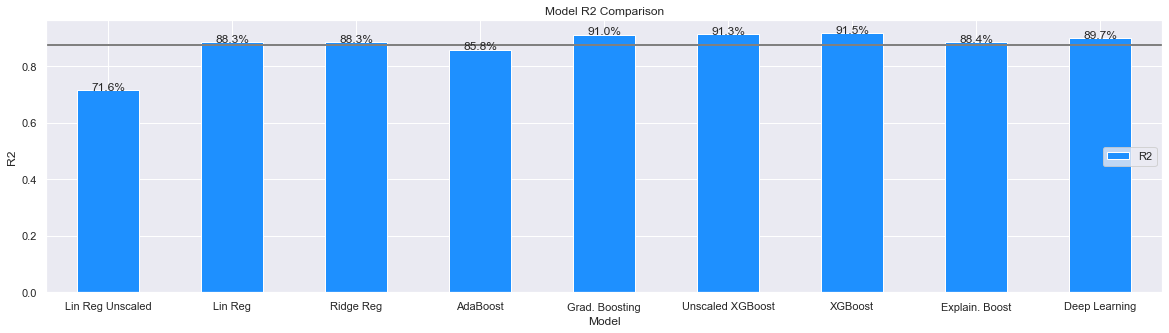

In [121]:
sns.set(font_scale=1)
ax = testing_tracker.plot.bar(x='Model', y='R2', rot=0,  color='DodgerBlue')
ax.axhline(testing_tracker['R2'].mean(), color='gray', linewidth=2)
ax.legend(loc='right')
ax.title.set_text('Model R2 Comparison')
ax.set( ylabel='R2')
y = testing_tracker['R2']
for i in range(len(y)):
    ax.text(i, y[i], str(int(round(y[i],3)* 1000)/10) + '%', ha='center')

<h3>Deep learning performed better than the linear models & explainable boosting, but did not perform as well as gradient boosting or XGBoost</h3>

<h2>Step 3: Model Explainability</h2>

<h3>Explainable Boosting Machine Feature Importance</h3>
<h4>It's no longer enough to simply show that a model performs, we now need to explain why a model predicts what it does. For example, if a loan product is indirectly discriminating against a segment of customers the company could be at risk. EBM is a glass box model that can show directy what features led to a model decision, but other black box models such as XGBoost can utilize Shapley values. 
    
Shapley values estimate the marginal impact of a feature. We will compare the EBM feature importance to the Shap values for XGBoost to see if the models are consistently using the same features to come up with their predictions.</h4>

In [122]:
from interpret import show

ebm_global = ebm.explain_global()
show(ebm_global)

<!-- http://127.0.0.1:7001/140293685565136/ -->

<h2>XGBoost Shapley Values</h2>

In [123]:
import shap

explainer = shap.TreeExplainer(xgbr)
shap_values = explainer(Xtrain)

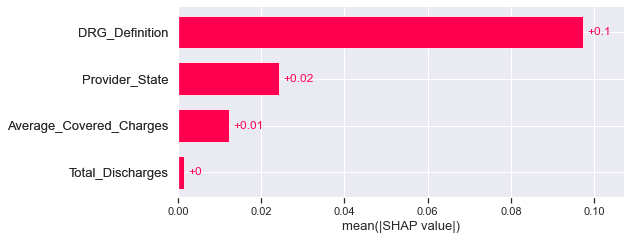

In [124]:
shap.plots.bar(shap_values, max_display=20)

<h2>Deep Learning Shapley Values</h2>

In [125]:
explainer = shap.KernelExplainer(model, Xtrain.iloc[:50,:])

In [126]:
shap_values = explainer.shap_values(Xtrain[:1000], nsamples=500)

  0%|          | 0/1000 [00:00<?, ?it/s]

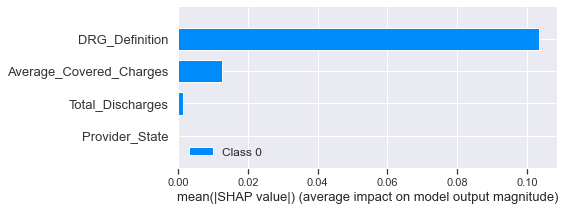

In [127]:
shap.summary_plot(shap_values, plot_type='bar',max_display=20, feature_names = Xtrain.columns)

<h3>Deep Learning, XGBoost & EBM all have DRG (Diagnosis Related Group) definition as the most important variable. XGBoost had the highest test accuracy so we will utilize XGBoost in our "production model".</h3>